In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap

from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from sklearn.ensemble import RandomForestRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from skll.metrics import spearman, pearson

RANDOM_STATE = 420
N_JOBS = 8

In [2]:
# TODO: scale to 1 second total elapsed time

%matplotlib inline

workdir = "/Users/youngsun/repos/github/perftasks/ML/interpretability/tutorials/IMLwPython"

statspath = os.path.join(workdir, "clubb_stats.csv")
stats_df = pd.read_csv(statspath, sep=",")
etime_unit = stats_df[' Selected Instance Median (ms)'].iloc[0]*1.E-6
#etime_unit = stats_df[' Selected Instance Median (ms)'].iloc[0]

datapath = os.path.join(workdir, "clubb_folding.csv")
column_names = ["region", "group", "papi", "timestamp", "value", "accum_value"]

data_df = pd.read_csv(datapath, sep=";", names=column_names)

data_df = data_df.drop('accum_value', axis=1)

regions = {}
for region, df_region in data_df.groupby(['region', 'group']):
    regions[region] = df_region.drop(['region', 'group', 'timestamp'], axis=1)

if len(regions) == 0:
    print("No region is found in data file.")
    data_df = None
elif len(regions) > 1:
    print("More than one regions are found. Picked a region randomly.")
    data_df = regions[next(iter(regions))]
else:
    data_df = regions[next(iter(regions))]

data_df = data_df[data_df.papi.str.endswith('_per_ins') == True]
data_df = data_df.set_index([data_df.groupby('papi').cumcount(), 'papi']).value.unstack()
data_df = data_df.replace([np.inf, -np.inf, -np.nan], np.nan)
#data_df = data_df.interpolate(method='zero').fillna(method='bfill') # back fill
data_df = data_df.interpolate(method='zero') # 
data_df = data_df.iloc[6:]                   # remove the first six nan rows
data_df = data_df.loc[:, (data_df != 0).any(axis=0)]
data_df.index.rename('time', inplace=True)



#print(data_df.isnull().values.any())

#data_df['etime'] = etime_unit
#data_df['etime'] = np.random.randint(1, 6, data_df.shape[0])

# check if exist nan, inf values
#print(data_df[data_df.isin([np.nan, np.inf, -np.inf]).any(1)])

# check data values
#data_df.head()

#data_df.plot()
#for title, group in data_df.groupby('papi'):
#    group.plot(x='timestamp', y='value', title=title)

# Get the data for the position we want, in this case it's DE
#pos_df = data_df2.loc[data_df2.Pos=='DE'].copy().reset_index(drop=True)

In [3]:
# what we want to predict
#target = 'etime'
#target = 'PAPI_TOT_CYC'
target = 'PAPI_TOT_CYC_per_ins'

#features = data_df.columns[data_df.columns.str.startswith('PAPI')].values
temp_df = data_df.loc[:, data_df.columns != target]
drop_columns = ['PAPI_REF_CYC_per_ins', 'PAPI_RES_STL_per_ins', 'PAPI_STL_CCY_per_ins', 'PAPI_FUL_CCY_per_ins',
                'PAPI_FUL_ICY_per_ins', 'PAPI_LST_INS_per_ins']
temp_df = temp_df.drop(drop_columns, axis=1)
features = temp_df.columns[temp_df.columns.str.startswith('PAPI')].values

print(features)
num_features = len(features)

X_df, X_test_df, y_df, y_test_df = train_test_split(
    data_df[features], data_df[target], test_size=0.33,
    random_state=RANDOM_STATE, shuffle=True)

# Split the data into train and test sets
#train_df = pos_df.loc[pos_df.Year <= 2011]
#test_df = pos_df.loc[pos_df.Year.isin([2012, 2013, 2014, 2015])]

X_all = data_df[features].values
y_all = data_df[target].values

X = X_df.values
y = y_df.values

X_test = X_test_df.values
y_test = y_test_df.values

print(X_all.shape)

['PAPI_BR_CN_per_ins' 'PAPI_BR_INS_per_ins' 'PAPI_BR_MSP_per_ins'
 'PAPI_BR_NTK_per_ins' 'PAPI_BR_PRC_per_ins' 'PAPI_BR_TKN_per_ins'
 'PAPI_BR_UCN_per_ins' 'PAPI_CA_CLN_per_ins' 'PAPI_CA_INV_per_ins'
 'PAPI_CA_ITV_per_ins' 'PAPI_CA_SHR_per_ins' 'PAPI_CA_SNP_per_ins'
 'PAPI_DP_OPS_per_ins' 'PAPI_L1_DCM_per_ins' 'PAPI_L1_ICM_per_ins'
 'PAPI_L1_LDM_per_ins' 'PAPI_L1_STM_per_ins' 'PAPI_L1_TCM_per_ins'
 'PAPI_L2_DCA_per_ins' 'PAPI_L2_DCM_per_ins' 'PAPI_L2_DCR_per_ins'
 'PAPI_L2_DCW_per_ins' 'PAPI_L2_ICA_per_ins' 'PAPI_L2_ICM_per_ins'
 'PAPI_L2_ICR_per_ins' 'PAPI_L2_LDM_per_ins' 'PAPI_L2_STM_per_ins'
 'PAPI_L2_TCA_per_ins' 'PAPI_L2_TCM_per_ins' 'PAPI_L2_TCR_per_ins'
 'PAPI_L2_TCW_per_ins' 'PAPI_L3_DCA_per_ins' 'PAPI_L3_DCR_per_ins'
 'PAPI_L3_DCW_per_ins' 'PAPI_L3_ICA_per_ins' 'PAPI_L3_ICR_per_ins'
 'PAPI_L3_TCA_per_ins' 'PAPI_L3_TCM_per_ins' 'PAPI_L3_TCR_per_ins'
 'PAPI_L3_TCW_per_ins' 'PAPI_LD_INS_per_ins' 'PAPI_MEM_WCY_per_ins'
 'PAPI_PRF_DM_per_ins' 'PAPI_SR_INS_per_ins' 'PAPI_STL_ICY_per

In [ ]:
# searching best parameter set

# the modeling pipeline
pipe = Pipeline([("imputer", Imputer()),
    ("estimator", RandomForestRegressor(random_state=RANDOM_STATE))])

# We use spearman's rank correlation as the scoring metric since
# we are concerned with ranking the players
spearman_scorer = make_scorer(spearman)
#pearson_scorer = make_scorer(pearson)

# the hyperparamters to search over, including different imputation strategies
rf_param_space = {
   'imputer__strategy': Categorical(['mean', 'median', 'most_frequent']),
   'estimator__max_features': Integer(1, num_features),
   'estimator__n_estimators': Integer(50, 500), 
   'estimator__min_samples_split': Integer(2, 200),
}
# create our search object
search = BayesSearchCV(pipe, 
                    rf_param_space, 
                    cv=10,
                    n_jobs=N_JOBS, 
                    verbose=0, 
                    error_score=-9999,
                    #scoring=spearman_scorer, 
                    random_state=RANDOM_STATE,
                    return_train_score=True, 
                    n_iter=75)

# fit the model
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    search.fit(X, y) 

# best model parameters
print(search.best_params_)

# get the estimator and imputer from our pipeline, which will be used
# as we try and interpret our model
estimator = search.best_estimator_.named_steps['estimator']
imputer = search.best_estimator_.named_steps['imputer']
y_pred = search.predict(X_test)


In [4]:
# in case that we already know the best paramenter set
# saving best paramenter set for clubb data
# {  'estimator__max_features': 31,
#    'estimator__min_samples_split': 1419,
#    'estimator__n_estimators': 2656,
#    'imputer__strategy': 'median'}

# for PAPI_RES_STL ???
#{'estimator__max_features': 31, 'estimator__min_samples_split': 142,
# 'estimator__n_estimators': 287, 'imputer__strategy': 'median'}

# for PAPI_TOT_INS
#{'estimator__max_features': 14, 'estimator__min_samples_split': 2,
# 'estimator__n_estimators': 500, 'imputer__strategy': 'most_frequent'}

# for PAPI_TOT_CYC
#{'estimator__max_features': 1, 'estimator__min_samples_split': 13,
# 'estimator__n_estimators': 50, 'imputer__strategy': 'mean'}

# for PAPI_TOT_CYC_per_ins
#{'estimator__max_features': 35, 'estimator__min_samples_split': 2,
# 'estimator__n_estimators': 500, 'imputer__strategy': 'most_frequent'}

#pipe = Pipeline([("imputer", Imputer(strategy='median')), ("estimator",
#    RandomForestRegressor( max_features=31, min_samples_split=1419,
#           n_estimators=2656, random_state=RANDOM_STATE))])


pipe = Pipeline([("imputer", Imputer(strategy='most_frequent')), ("estimator",
    RandomForestRegressor( max_features=35, min_samples_split=2,
           n_estimators=500, random_state=RANDOM_STATE))])

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    pipe.fit(X, y)
    
estimator = pipe.named_steps['estimator']
imputer = pipe.named_steps['imputer']
y_pred = pipe.predict(X_test)

print(y_pred[:10])

[0.36627999 0.75299888 0.56365516 0.31893151 0.32138652 0.82896536
 0.42378746 0.85376348 0.45000671 0.53223155]


In [23]:
# Verifying model accuracy

spearman_scorer = make_scorer(spearman)
#pearson_scorer = make_scorer(pearson)

# evaluation
model_test_score = spearman_scorer(pipe, X_test, y_test)
#model_test_score = pearson_scorer(pipe, X_test, y_test)
print(model_test_score)

0.9956634729895445


In [5]:

#print(estimator.feature_importances_[:10])
feature_importances = pd.DataFrame(estimator.feature_importances_,
    index = features,
    columns=['importance']).sort_values('importance',
    ascending=False)
print(feature_importances[:10])

                     importance
PAPI_L1_TCM_per_ins    0.167219
PAPI_CA_SNP_per_ins    0.082444
PAPI_LD_INS_per_ins    0.077369
PAPI_L1_DCM_per_ins    0.061340
PAPI_DP_OPS_per_ins    0.060191
PAPI_CA_INV_per_ins    0.058312
PAPI_CA_ITV_per_ins    0.050361
PAPI_BR_NTK_per_ins    0.042927
PAPI_L3_ICR_per_ins    0.029547
PAPI_L3_ICA_per_ins    0.027885


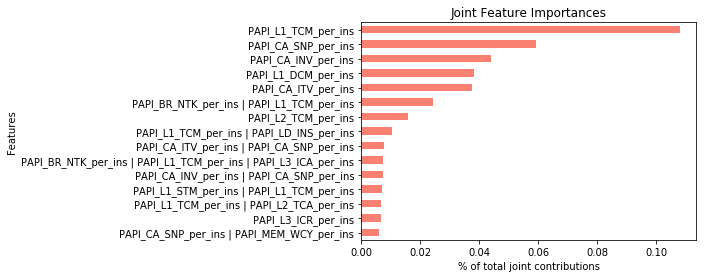

In [6]:
import treeinterpreter.treeinterpreter as ti

test_X_imp = imputer.transform(X_all)

joint_pred, joint_bias, joint_contrib = ti.predict(estimator,
                                                   test_X_imp,
                                                   joint_contribution=True)

def create_ordered_joint_contrib_df(contrib):
    """
    Creates a dataframe from the joint contribution info, where the
    feature combinations are ordered (in descending fashion) by the absolute
    value of the joint contribution.
    """
    df = pd.DataFrame(contrib, columns=['feat_interaction', 'contribution'])
    # get the reordered index    
    new_idx = (df.contribution.abs()
                              .sort_values(inplace=False, ascending=False)
                              .index)
    df = df.reindex(new_idx).reset_index(drop=True)
    return df

# add the names of the feats to the joint contributions
joint_contrib_w_feat_names = []
# for each observation in the join contributions
for obs in joint_contrib:
    # create a list
    obs_contrib = []
    # for each tuple of column indexes
    for k in obs.keys():
        # get the associated feature names
        feature_combo = [features[i] for i in k]
        # get the contribution value
        contrib = obs[k]
        # store that information in the observation individual list
        obs_contrib.append([feature_combo, contrib])
    # append that individual to the large list containing each observations
    # joint feature contributions
    joint_contrib_w_feat_names.append(obs_contrib)

# create an ordered dataframe for each player
joint_contrib_dfs = [create_ordered_joint_contrib_df(contrib)
                     for contrib in joint_contrib_w_feat_names]
# now combine them all
joint_contrib_df = pd.concat(joint_contrib_dfs, keys=features, names=['papi'])

# edit feat_interaction column so the values are strings and not lists
joint_contrib_df['feat_interaction'] = joint_contrib_df.feat_interaction.apply(' | '.join) 

# first get the sum of the absolute values for each joint feature contribution
abs_imp_joint_contrib = (joint_contrib_df.groupby('feat_interaction')
                                          .contribution
                                          .apply(lambda x: x.abs().sum())
                                           .sort_values(ascending=False))

# then calculate the % of total contribution by dividing by the sum of all absolute vals
rel_imp_join_contrib = abs_imp_joint_contrib / abs_imp_joint_contrib.sum()

rel_imp_join_contrib.head(15)[::-1].plot(kind='barh', color='salmon', 
                                              title='Joint Feature Importances');
plt.ylabel('Features')
plt.xlabel('% of total joint contributions');

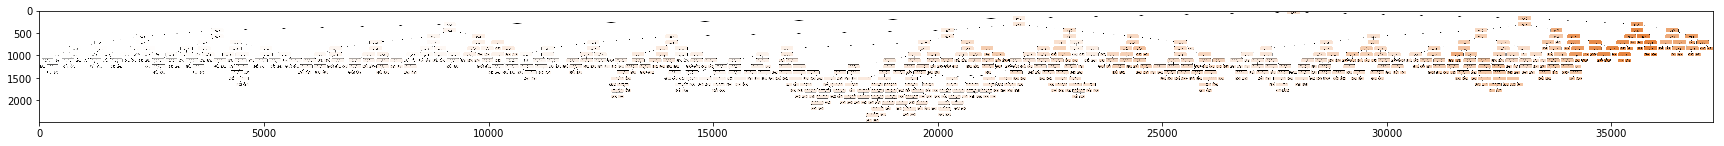

In [8]:
from io import StringIO, BytesIO
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
import matplotlib.image as mpimg

plt.rcParams['figure.figsize'] = [30, 20]

# Get all trees of depth 2 in the random forest
#depths2 = [tree for tree in estimator.estimators_ if tree.tree_.max_depth==2]
depths2 = [tree for tree in estimator.estimators_]

# grab the first one
treeid = np.random.randint(0, len(depths2))
tree = depths2[treeid]


# plot the tree
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=features,
                filled=True, rounded=True, special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
png_str = graph.create_png(prog='dot')

# treat the dot output string as an image file
bio = BytesIO()
bio.write(png_str)
bio.seek(0)
img = mpimg.imread(bio)

# plot the image
imgplot = plt.imshow(img, aspect='equal')

# simple exmaple of a player with a 4.6 Forty and a Wt of 260 lbs
#example = np.array([4.6, 260, 0, 0, 0, 0, 0, 0])
#eli5.explain_prediction_df(tree, example, feature_names=self.features)

#example_prec = tree.predict(example.reshape(1,-1))

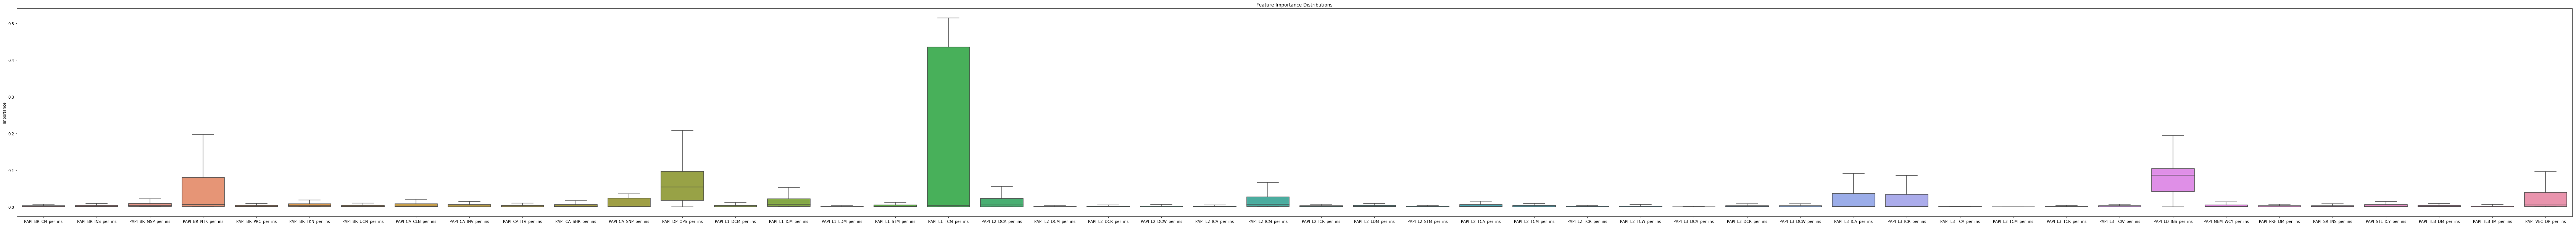

In [9]:
import eli5
import seaborn as sns

plt.rcParams['figure.figsize'] = [120, 10]

# create our dataframe of feature importances
feat_imp_df = eli5.explain_weights_df(estimator, feature_names=features)

# get the feature importances from each tree and then visualize the
# distributions as boxplots
all_feat_imp_df = pd.DataFrame(data=[tree.feature_importances_ for tree in 
                                     estimator],
                               columns=features)
#remain_features = ['PAPI_BR_MSP_per_ins',  'PAPI_L1_DCM_per_ins', 'PAPI_L1_TCM_per_ins',
#                  'PAPI_L2_TCM_per_ins', 'PAPI_L3_TCR_per_ins',
#                  'PAPI_LD_INS_per_ins', 'PAPI_TLB_IM_per_ins', 'PAPI_L3_VEC_DP_ins']
#for feature in features:
#    if feature not in remain_features:
#        all_feat_imp_df.drop(feature, axis=1, inplace=True)
#print(all_feat_imp_df)
(sns.boxplot(data=all_feat_imp_df, showfliers=False)
        .set(title='Feature Importance Distributions',
             ylabel='Importance'));

In [10]:
print(features)
# create our SHAP explainer
shap_explainer = shap.TreeExplainer(estimator)

test_X_imp = imputer.transform(X_all)


# calculate the shapley values for our test set
test_shap_vals = shap_explainer.shap_values(test_X_imp)
test_shap_interaction_values = shap_explainer.shap_interaction_values(data_df[features])

# load JS in order to use some of the plotting functions from the shap
# package in the notebook
shap.initjs()


test_X_imp_df = pd.DataFrame(test_X_imp, columns=features)

# get the prediction and actual target values to plot
#y_test_and_pred_df = pd.DataFrame(np.column_stack((y_test, y_pred)),
#    index=X_test_df.index,
#    columns=['true_etime', 'pred_etime'])




['PAPI_BR_CN_per_ins' 'PAPI_BR_INS_per_ins' 'PAPI_BR_MSP_per_ins'
 'PAPI_BR_NTK_per_ins' 'PAPI_BR_PRC_per_ins' 'PAPI_BR_TKN_per_ins'
 'PAPI_BR_UCN_per_ins' 'PAPI_CA_CLN_per_ins' 'PAPI_CA_INV_per_ins'
 'PAPI_CA_ITV_per_ins' 'PAPI_CA_SHR_per_ins' 'PAPI_CA_SNP_per_ins'
 'PAPI_DP_OPS_per_ins' 'PAPI_L1_DCM_per_ins' 'PAPI_L1_ICM_per_ins'
 'PAPI_L1_LDM_per_ins' 'PAPI_L1_STM_per_ins' 'PAPI_L1_TCM_per_ins'
 'PAPI_L2_DCA_per_ins' 'PAPI_L2_DCM_per_ins' 'PAPI_L2_DCR_per_ins'
 'PAPI_L2_DCW_per_ins' 'PAPI_L2_ICA_per_ins' 'PAPI_L2_ICM_per_ins'
 'PAPI_L2_ICR_per_ins' 'PAPI_L2_LDM_per_ins' 'PAPI_L2_STM_per_ins'
 'PAPI_L2_TCA_per_ins' 'PAPI_L2_TCM_per_ins' 'PAPI_L2_TCR_per_ins'
 'PAPI_L2_TCW_per_ins' 'PAPI_L3_DCA_per_ins' 'PAPI_L3_DCR_per_ins'
 'PAPI_L3_DCW_per_ins' 'PAPI_L3_ICA_per_ins' 'PAPI_L3_ICR_per_ins'
 'PAPI_L3_TCA_per_ins' 'PAPI_L3_TCM_per_ins' 'PAPI_L3_TCR_per_ins'
 'PAPI_L3_TCW_per_ins' 'PAPI_LD_INS_per_ins' 'PAPI_MEM_WCY_per_ins'
 'PAPI_PRF_DM_per_ins' 'PAPI_SR_INS_per_ins' 'PAPI_STL_ICY_per

In [11]:
# plot the explanation for a single prediction
#shap.force_plot(test_shap_vals[0, :], test_X_imp_df.iloc[0, :])
#shap.force_plot(test_X_imp_df.iloc[0, :], test_shap_vals[0, :])

# visualize the first prediction's explanation
shap.force_plot(shap_explainer.expected_value, test_shap_vals[0,:], test_X_imp_df.iloc[0,:])

In [12]:
shap.force_plot(shap_explainer.expected_value, test_shap_vals[:,:], test_X_imp_df.iloc[:,:])

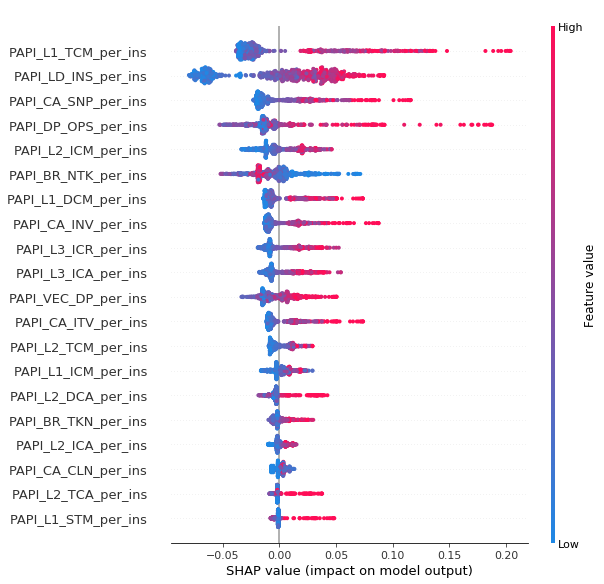

In [19]:
shap.summary_plot(test_shap_vals, test_X_imp_df, auto_size_plot=True)

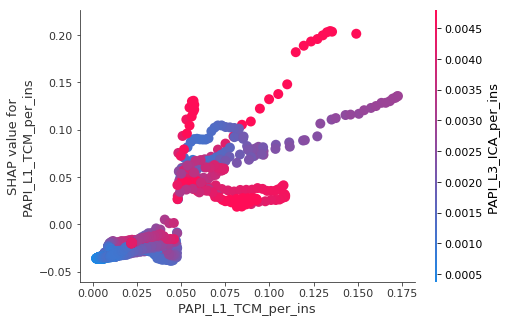

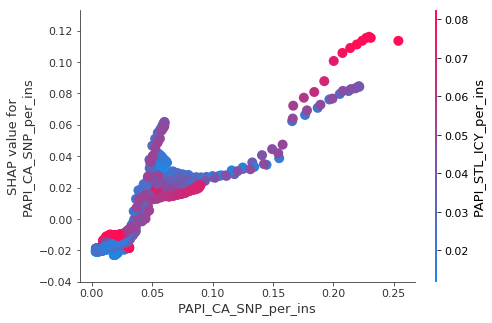

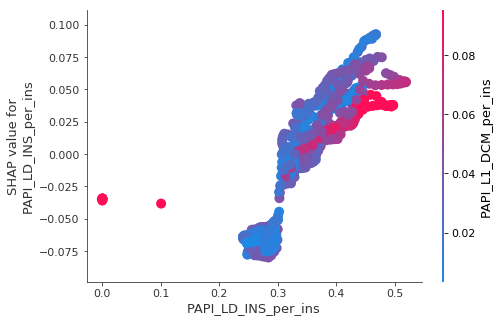

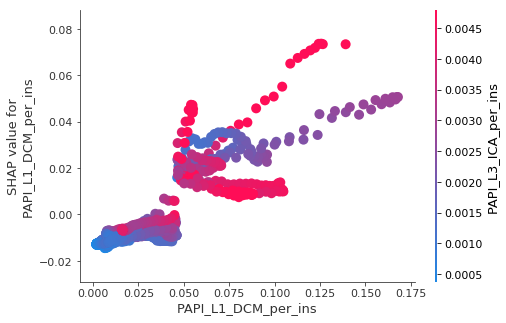

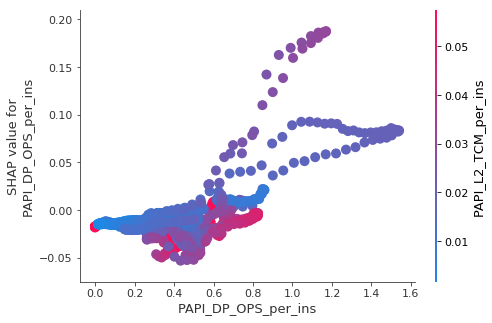

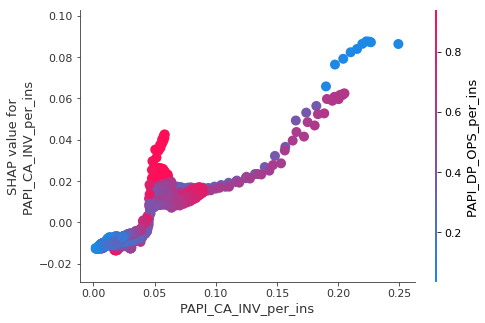

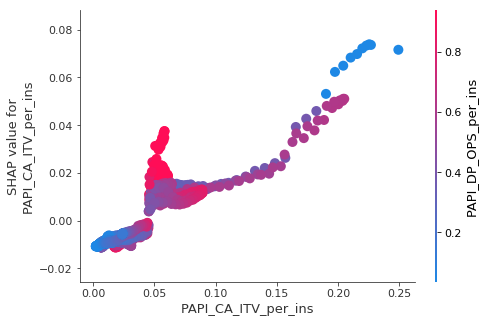

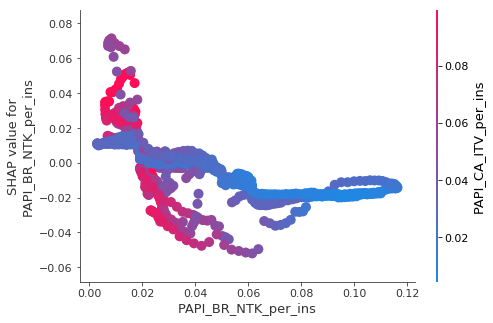

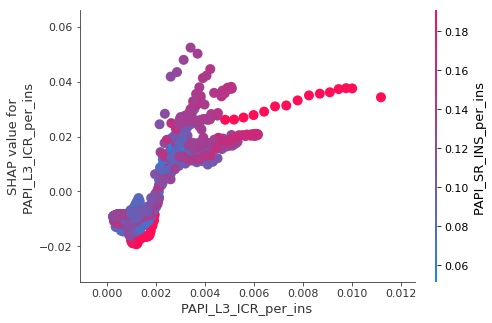

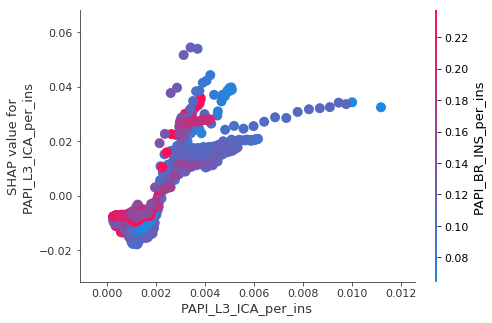

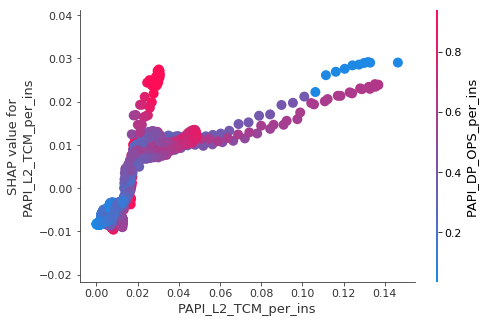

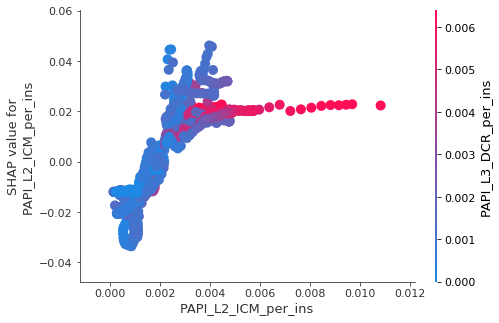

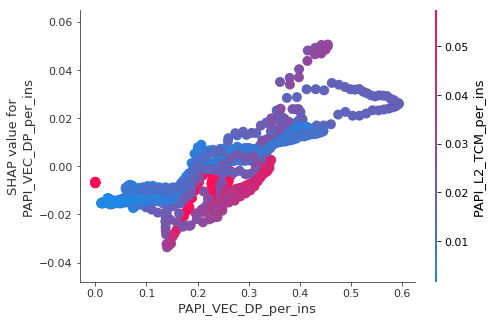

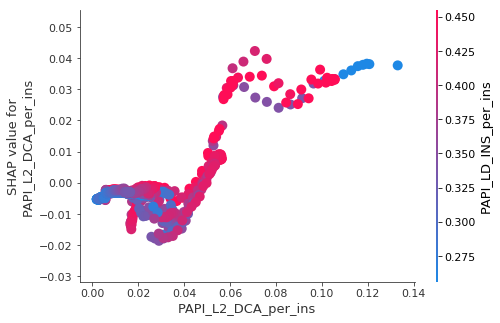

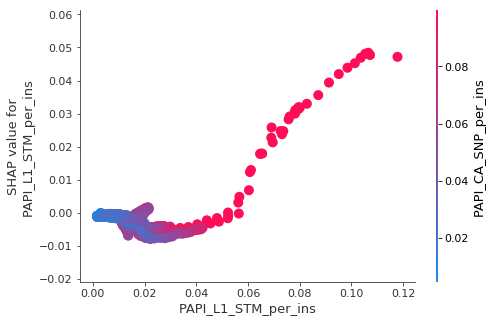

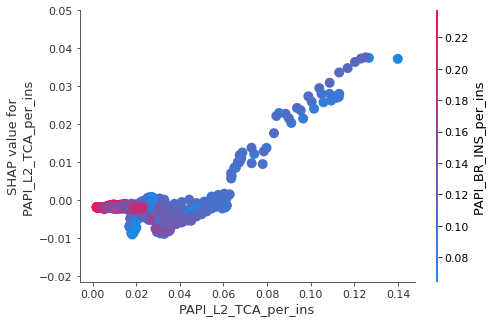

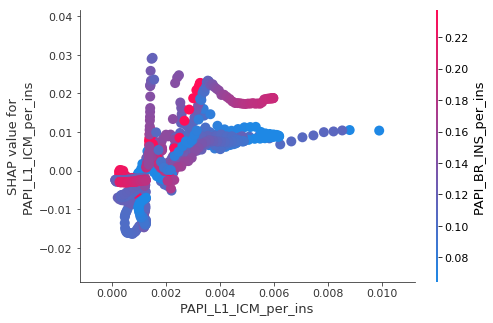

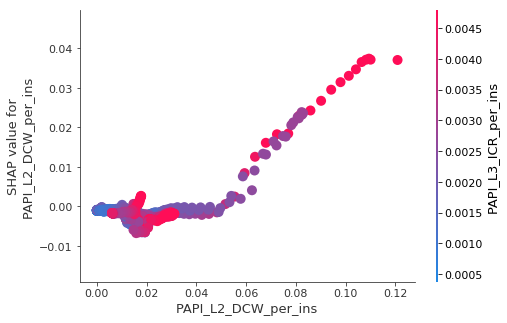

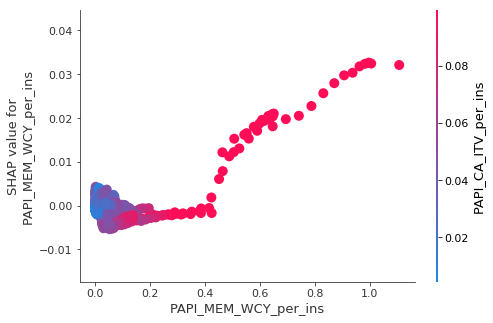

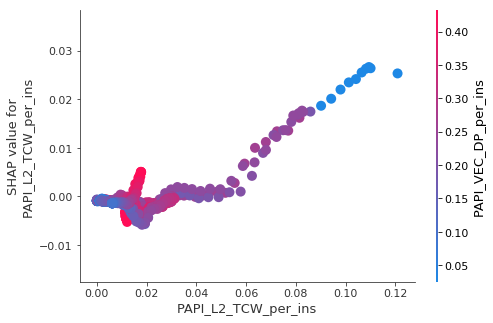

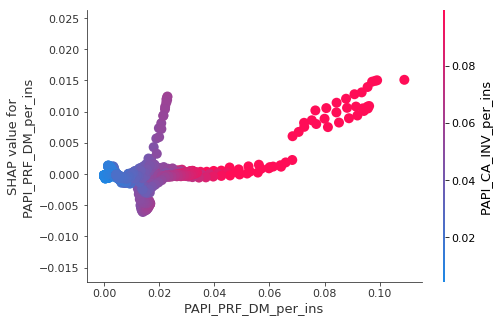

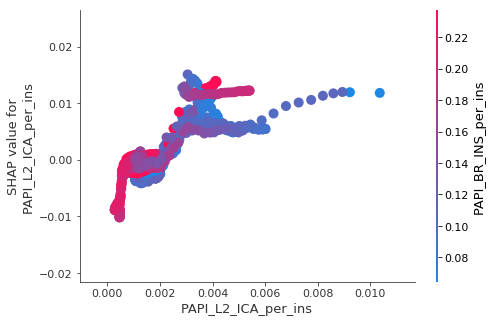

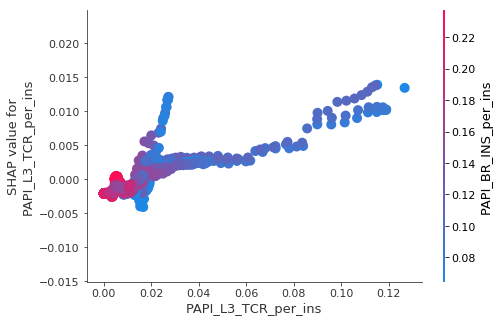

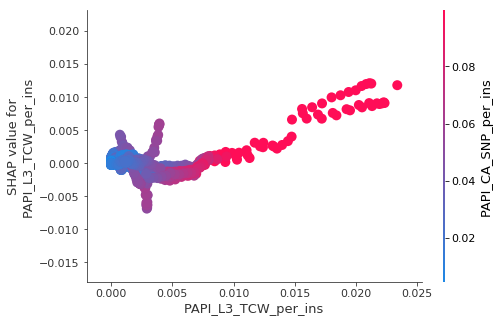

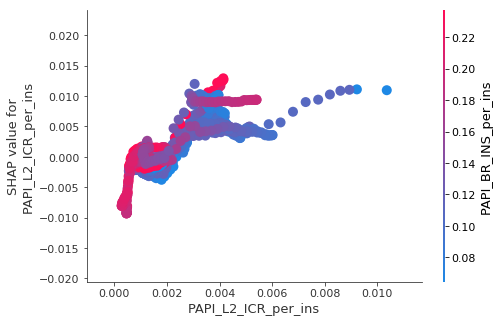

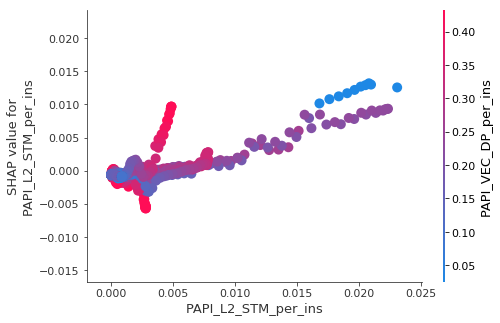

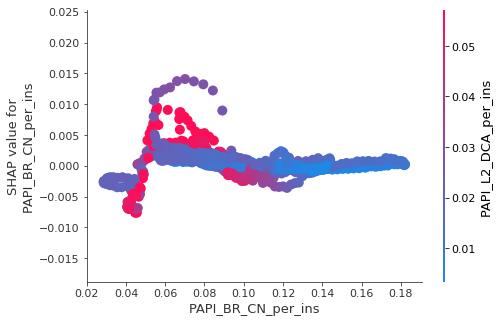

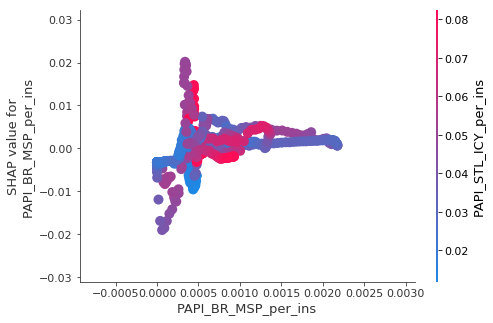

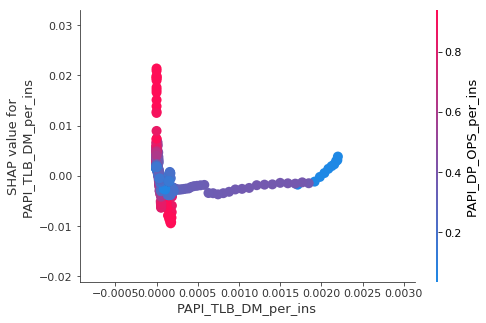

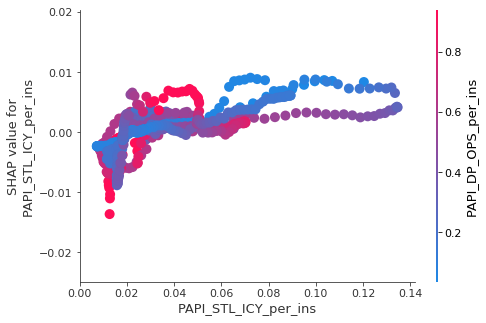

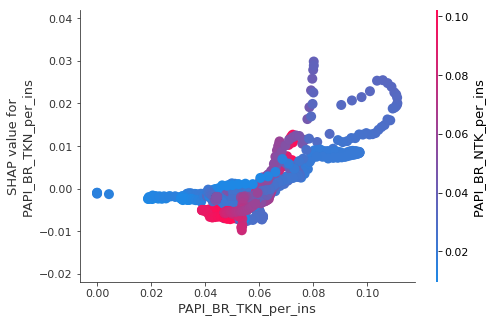

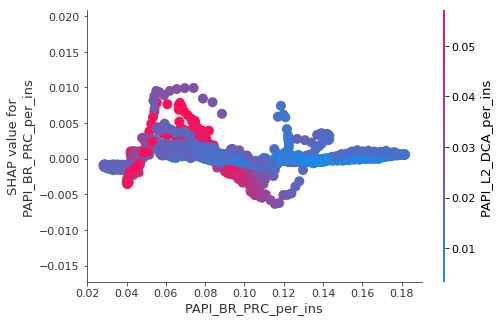

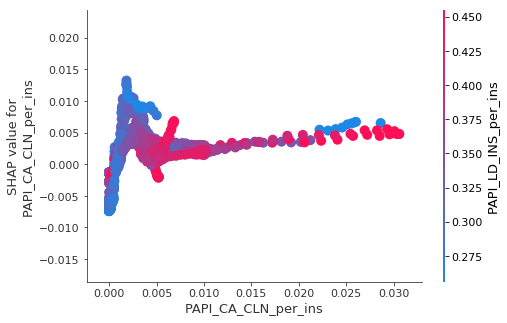

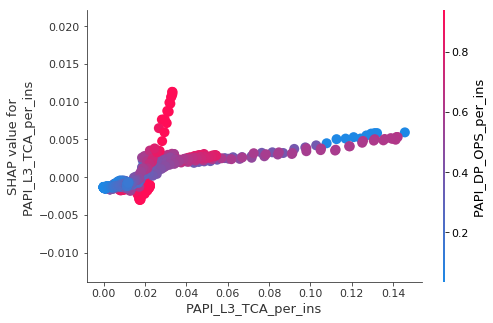

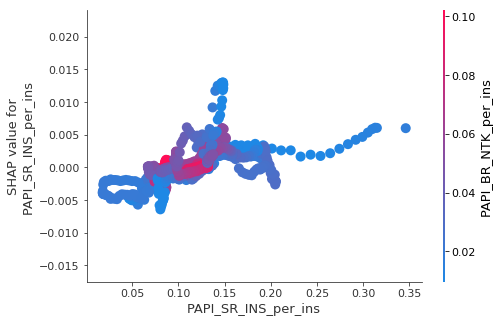

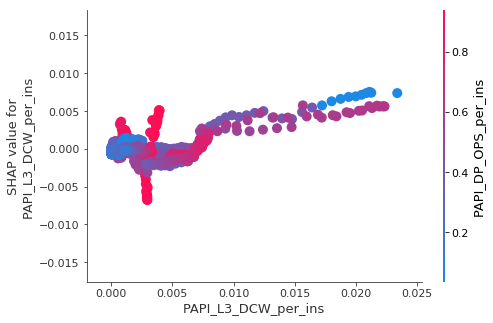

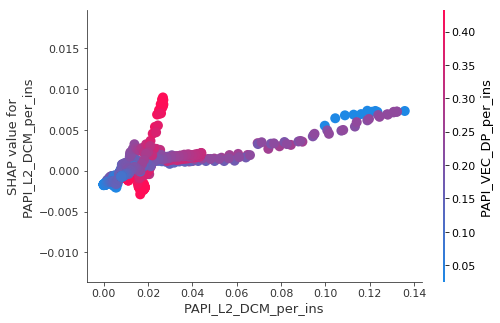

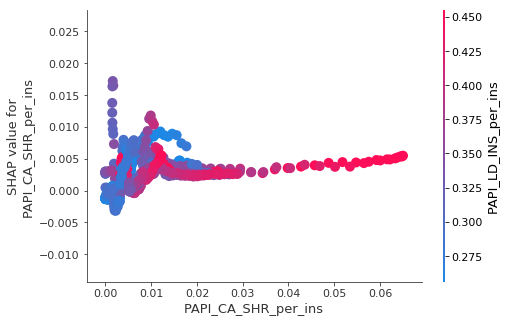

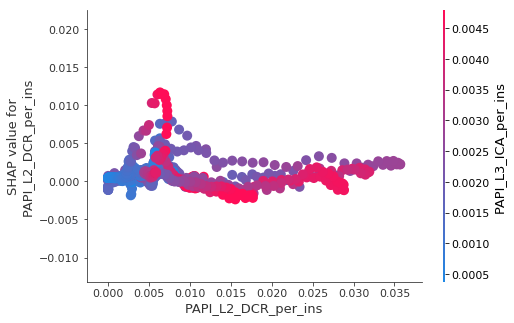

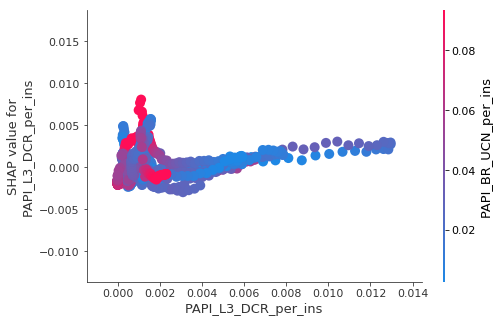

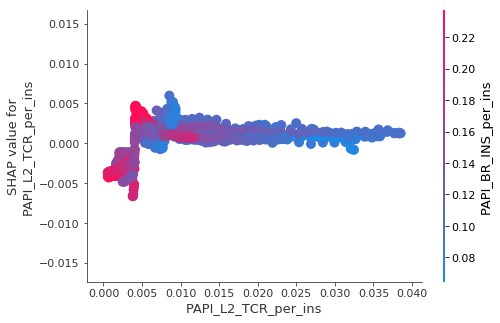

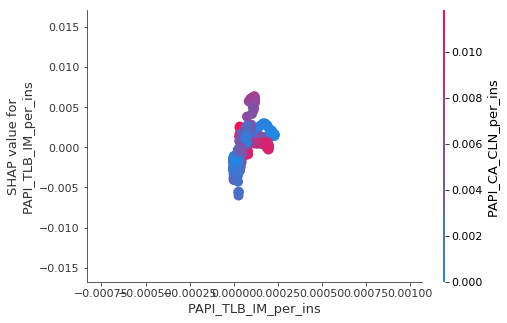

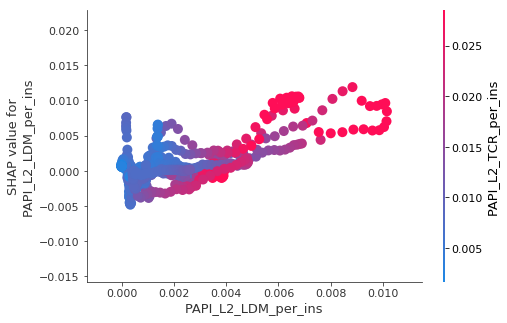

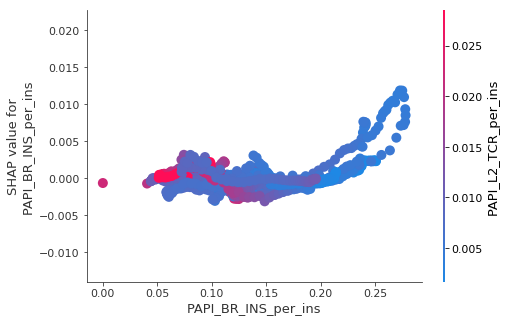

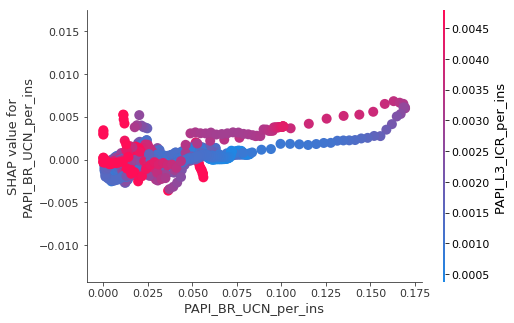

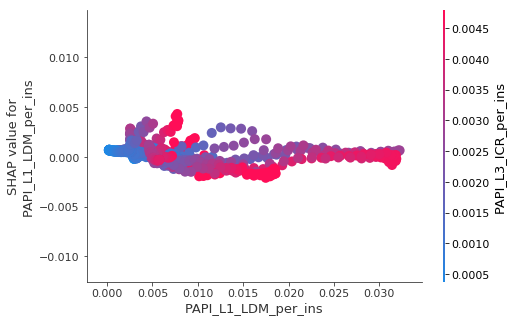

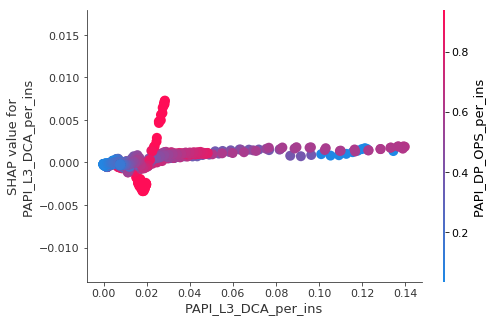

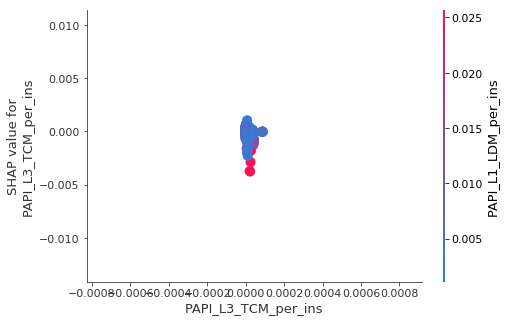

In [14]:
for feat in feature_importances.index.values:
    shap.dependence_plot(feat, test_shap_vals, test_X_imp_df, dot_size=100)

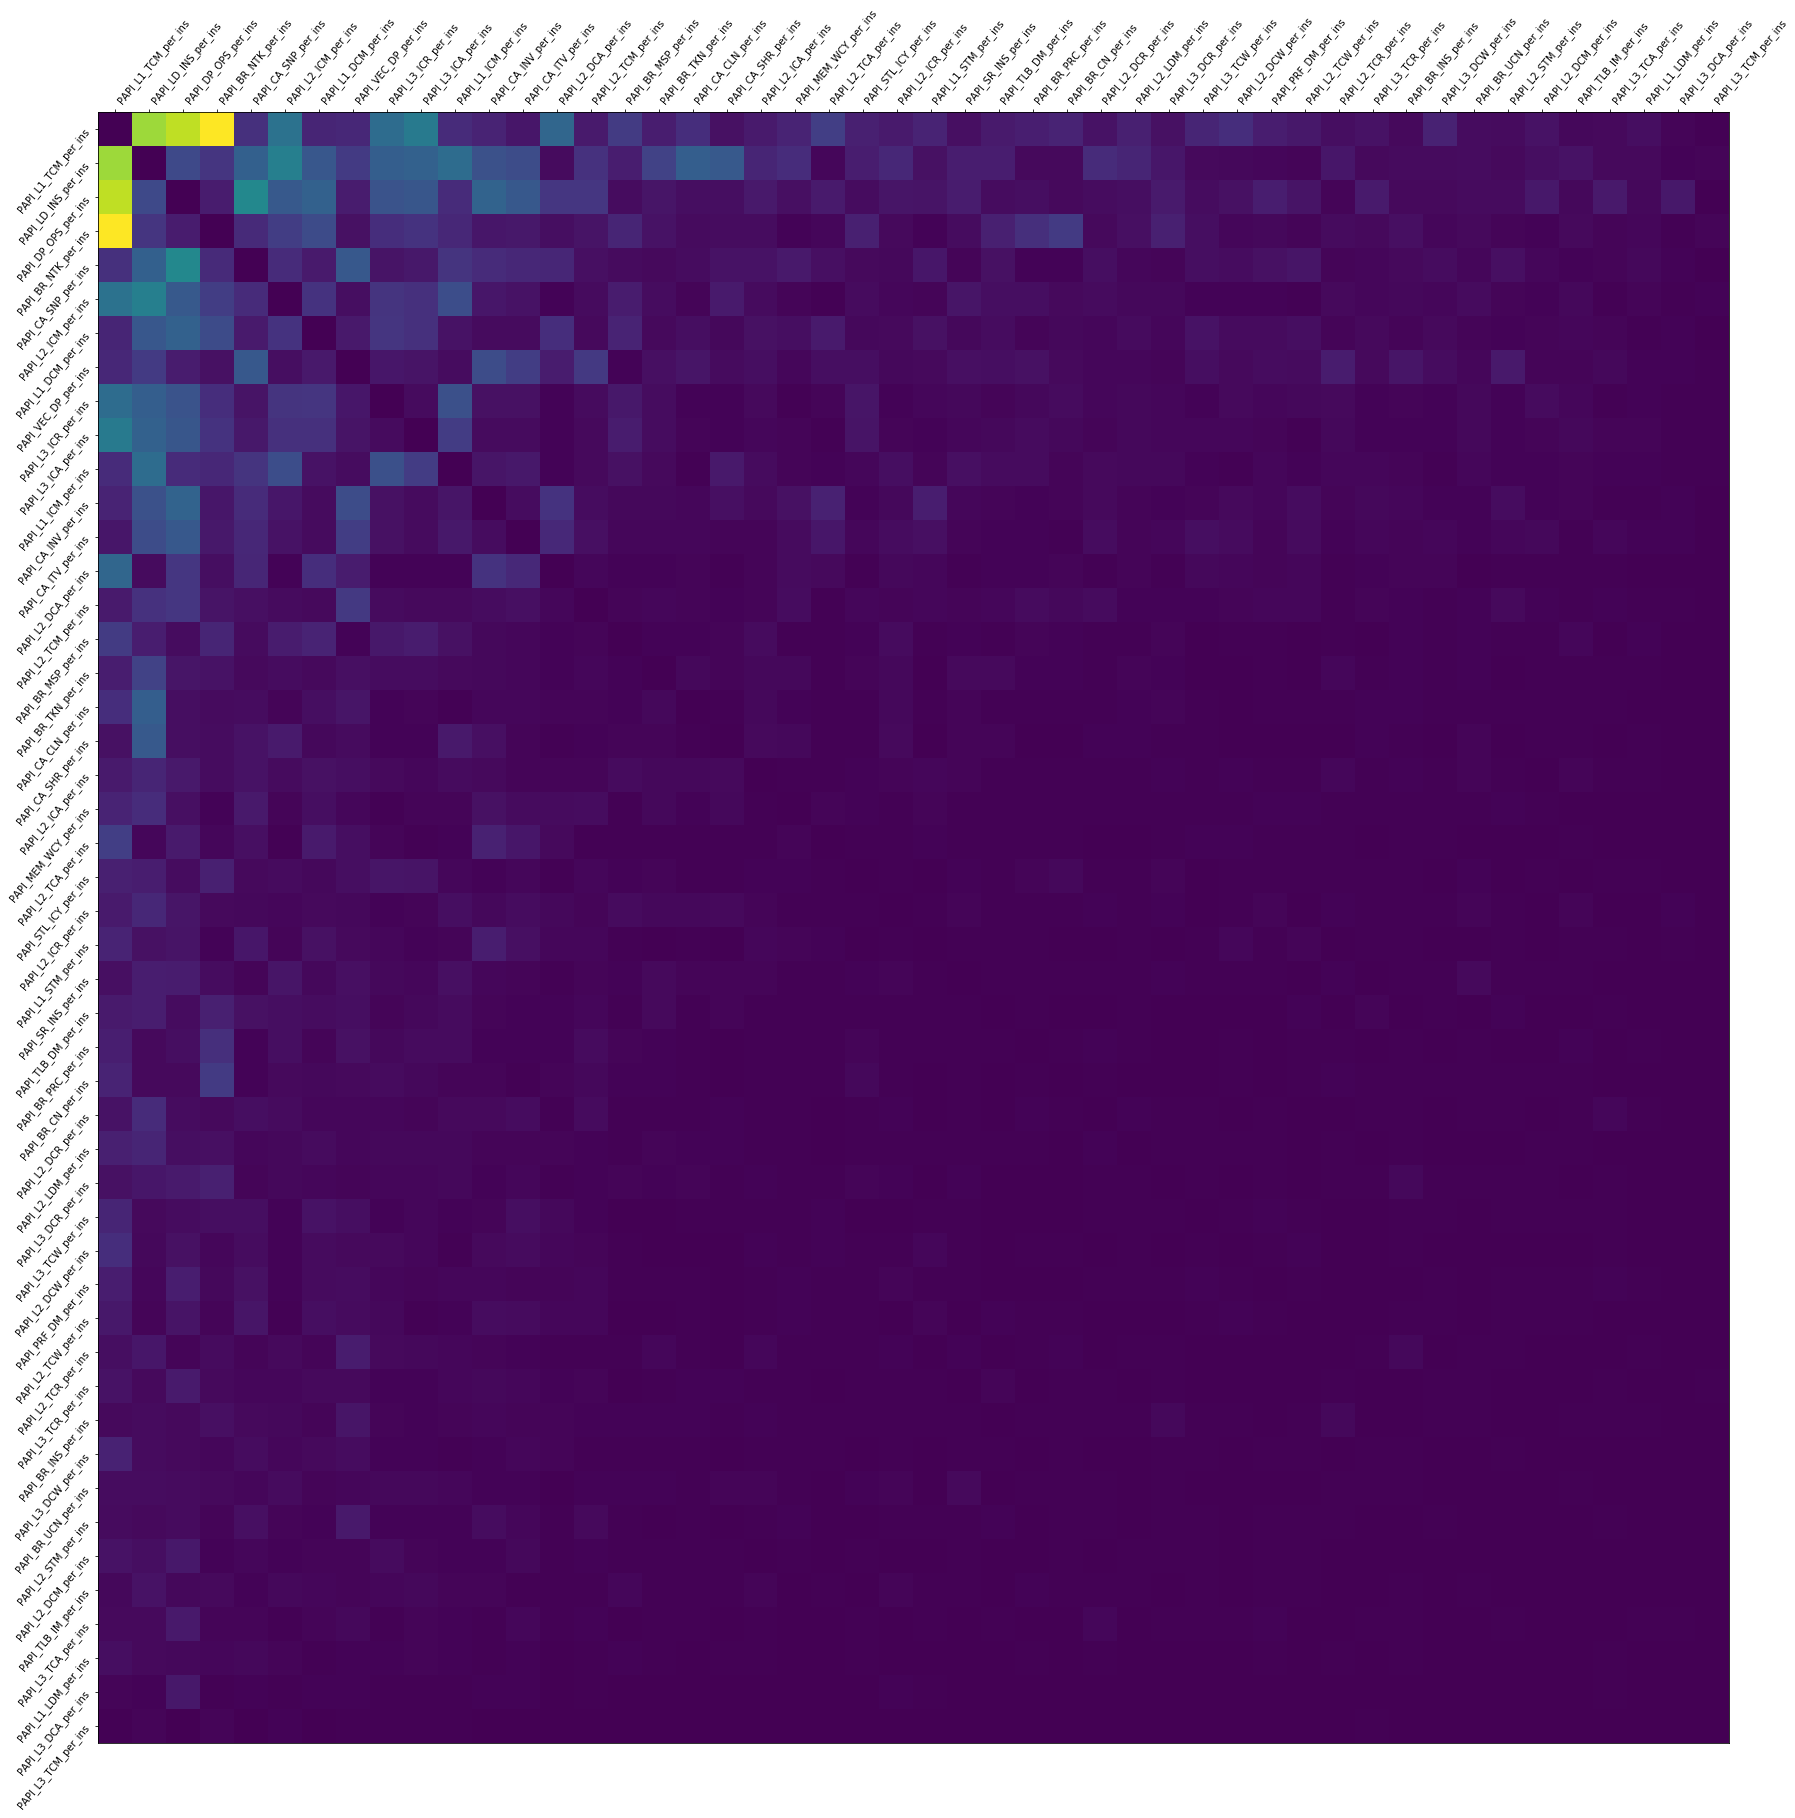

In [15]:
plt.rcParams['figure.figsize'] = [30, 30]

tmp = np.abs(test_shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
#plt.figure(figsize=(12,12))
plt.imshow(tmp2)
plt.yticks(range(tmp2.shape[0]), data_df[features].columns[inds], rotation=50.4, horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]), data_df[features].columns[inds], rotation=50.4, horizontalalignment="left")
plt.gca().xaxis.tick_top()
#plt.show()

In [38]:

test_shap_df = pd.DataFrame(np.column_stack((test_shap_vals, y_test_and_pred_df)),
                            columns= features + ['true_AV_pctile', 
                                                 'pred_AV_pctile'])
test_shap_df.sort_values('pred_AV_pctile', inplace=True)


title = 'SHAP Values for each prediction in the testing data'
# NOTE: this plot work only in command line
#fig = double_heatmap(test_shap_df[['true_AV_pctile', 'pred_AV_pctile']].T,
#                     test_shap_df[features].T, '%ile', 'SHAP Value',
#                     title=title, subplot_top=0.89)
#fig.axes[1].set_xlabel('Player');